# Deep learning using Lasagne in Nengo

Lasagne is a popular deep learning package.  It uses Theano as the underlying computational framework, but provides a higher level syntax to make it easier to construct neural networks.  The `nengo_lasagne` package is a backend for Nengo that compiles a Nengo network into a Lasagne implementation.  The network can then be trained using any of Lasagne's built-in optimization methods, or any other training scheme implemented in Theano.

From the user's perspective, constructing a network looks the same as any other Nengo model.  There are a few additional limitations (so the set of possible `nengo_lasagne` models is a subset of the overall space of Nengo models).  Some of these are due to features that I just haven't implemented yet, some may never be implemented (certain network structures are just not amenable to deep learning optimization, and it seems better to just be upfront about that rather than trying to shoe-horn them in).

In [11]:
%matplotlib inline

import lasagne
import matplotlib.pyplot as plt
import nengo # note: requires the `nengo_lasagne_compat` branch currently
import nengo_lasagne
import numpy as np

from nengo.processes import PresentInput

We need to define the overall inputs/outputs for the network, which will drive the training. The inputs and outputs should be 3D arrays, with shape `(batch_size, sequence_length, input/output d)`. This means that we're going to be processing `d` dimensional inputs/outputs, and processing `batch_size` vectors at a time (simultaneously). The sequence_length dimension defines the inputs that will be presented at each timestep (so each timestep will process one `(batch_size, d)` set of inputs).

Note that if there are no recurrent connections in the model then the sequential presentation of inputs makes no difference (since there is no internal state persisting between timesteps).  So in those cases the `batch_size` and `sequence_length` dimensions will be flattened (effectively processing all the timesteps at once).  But to keep things simple the inputs and outputs are still always specified as 3D arrays.

In [2]:
# in this demo we'll just use uniform random inputs
inputs = np.random.uniform(-1, 1, size=(3, 1000, 1)).astype(np.float32)

# an arbitrary output function
def target_func(inputs):
    return (inputs[0] + 1) * inputs[1] ** 2 + np.sin(inputs[2])
outputs = target_func(inputs)

# add in the empty sequence dimension
inputs = inputs[:, :, None]
outputs = outputs[:, None]

Now we can build the network itself.  `nengo_lasagne.default_config()` specifies a set of defaults that are useful for constructing these kinds of networks (used to override the standard Nengo defaults).

In [3]:
print(nengo_lasagne.default_config())

Parameters configured for Ensemble:
  bias: Choice(options=array([ 0.]))
  gain: Uniform(low=0.9, high=1.1)
  neuron_type: RectifiedLinear()
Parameters configured for Connection:
  synapse: None


In [4]:
with nengo.Network() as net, nengo_lasagne.default_config():
    # create nodes to define the input for the network (the same as
    # any other nengo model). note that the output of these nodes is 
    # just used when running the network, not during the training 
    # process (during training we'll use the input array defined above,
    # since we're not training online)
    # here we'll use the PresentInput process to feed in the inputs we
    # defined above, one at a time. we could just create one 3D node,
    # but we'll use 3 1D nodes for demonstration purposes.
    input_nodes = [nengo.Node(output=PresentInput(x.squeeze(axis=1), 
                                                  0.001))
                   for x in inputs]

    # create ensembles 
    ens0 = nengo.Ensemble(100, 2)
    ens1 = nengo.Ensemble(50, 1)
    
    # create connections (note that slicing works in the same
    # way as default nengo)
    nengo.Connection(input_nodes[0], ens0[0])
    nengo.Connection(input_nodes[1], ens0[1])
    nengo.Connection(input_nodes[2], ens1)

    # network output
    output_node = nengo.Node(size_in=1)
    
    # we can specify a function/transform on a connection. these
    # will be used to initialize the weights (using the standard
    # NEF nengo solvers)
    nengo.Connection(ens0, output_node,
                     function=lambda x: (x[0] + 1) * x[1] ** 2)
    nengo.Connection(ens1, output_node, function=np.sin)

    # add probes to nodes or neurons to collect their output
    p = nengo.Probe(output_node)

To access the `nengo_lasagne` backend we just pass the network we constructed to `nengo_lasagne.Simulator`. This will build  a Lasagne network with the same structure as the Nengo network defined above.  The weights in this network are untrained (set to whatever initial values are defined in the Nengo network).  

To train the network we call the `train` function on the constructed model.  The first parameter is a dict that maps `nengo.Nodes` to the input arrays we defined above (so the backend knows where to insert those inputs in the network).  The second parameter does the same for the targets.  `n_epochs` defines how many times the training process will iterate through the training data, and `minibatch_size` defines the size of the minibatches used within an epoch.  `optimizer` specifies one of the 
optimization methods defined in `lasagne.updates` (or this could be any Theano optimizer that implements the same interface).  The `optimizer_kwargs` will be passed to the optimizer function (in this case this is setting the learning rate).

In [5]:
sim = nengo_lasagne.Simulator(net)
sim.model.train(dict(zip(input_nodes, inputs)), {output_node: outputs},
                n_epochs=1000, minibatch_size=100, 
                optimizer=lasagne.updates.adagrad,
                optimizer_kwargs={"learning_rate": 1e-2})

checking network
building network
training network
training complete


Now we can run the trained network.  The probed output will be stored in the `sim.data` dictionary, as in standard Nengo.  Note that the probed outputs will have the same shape as described above, `(batch_size, sequence_len, d)`.  Batch size is just 1 when we run it this way, but we'll see an example where batch size is >1 later on.

In [6]:
sim.run_steps(1000)

# example target/actual outputs
print(outputs[:3])
print(sim.data[p][:, :3])

# root mean squared error
print(np.sqrt(np.mean(outputs - sim.data[p]) ** 2))


[[[-0.75969213]]

 [[-0.70920914]]

 [[ 0.00737938]]]
[[[-0.77597308]
  [-0.71367055]
  [-0.01978853]]]
0.00106978439726


For comparison, we can run the same network with the reference simulator:

In [7]:
sim = nengo.Simulator(net)
sim.run_steps(1000)

print(outputs[:3])
print(sim.data[p][None, :3])

print(np.sqrt(np.mean(outputs - sim.data[p][None, ...]) ** 2))

[[[-0.75969213]]

 [[-0.70920914]]

 [[ 0.00737938]]]
[[[-0.64639308]
  [ 0.0024047 ]
  [ 0.57044569]]]
0.0395942327666


## Recurrent networks

Recurrent networks work in exactly the same way. One new feature being demonstrated here is the option to pass a distribution for the transform parameter.  This will cause the initial weights to be sampled from that distribution.  Any of the distributions in `nengo.dists` can be used, or any of the distributions in `lasagne.init` (access them via `nengo_lasagne.init` to wrap them in a Nengo distribution).

Here we're implementing a 1D integrator:

checking network
building network
training network
training complete


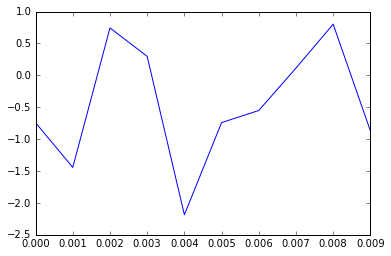

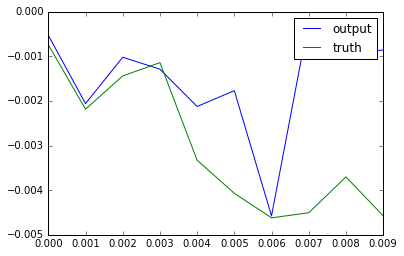

In [8]:
batch_size = 1000
sig_len = 10
dt = 1e-3
inputs = np.random.randn(batch_size, sig_len, 1).astype(np.float32)
targets = np.cumsum(inputs, axis=1) * dt

with nengo.Network() as net, nengo_lasagne.default_config():
    # note that here we're using a different test input than the training input
    input_node = nengo.Node(output=nengo.processes.WhiteNoise(scale=False))
    ens = nengo.Ensemble(50, 1)
    output_node = nengo.Node(size_in=1)

    nengo.Connection(input_node, ens)
    nengo.Connection(ens.neurons, ens.neurons,
                     transform=nengo_lasagne.init.GlorotUniform())
    nengo.Connection(ens, output_node)

    input_p = nengo.Probe(input_node)
    output_p = nengo.Probe(output_node)

sim = nengo_lasagne.Simulator(net, dt=dt)
sim.model.train({input_node: inputs}, {output_node: targets},
                n_epochs=1000, minibatch_size=100,
                optimizer_kwargs={"learning_rate": 1e-2})
sim.run_steps(sig_len)

truth = np.cumsum(sim.data[input_p], axis=1)*dt

plt.figure()
plt.plot(sim.trange(), sim.data[input_p][0])

plt.figure()
plt.plot(sim.trange(), sim.data[output_p][0], label="output")
plt.plot(sim.trange(), truth[0], label="truth")
plt.legend()

When we run the network as above, `nengo_lasagne` generates the inputs by checking the output of the input Nodes.  However, the inputs can also be specified directly by passing a `dict` mapping nodes to input arrays (the same format used when specifying the training inputs).  This can be useful to run a batch of inputs simultaneously:

In [9]:
sim.run_steps(sig_len, {input_node: np.random.randn(batch_size, sig_len, 1).astype(np.float32)})

truth = np.cumsum(sim.data[input_p], axis=1)*dt

print(sim.data[output_p].shape)
print(np.sqrt(np.mean((truth - sim.data[output_p])**2)))

(1000, 10, 1)
0.00170225


Or using the NEF to initialize the weights:

checking network
building network
training network
training complete
(1000, 10, 1)
0.00147614


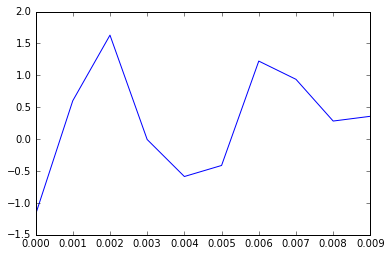

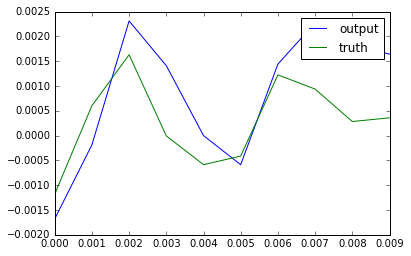

In [10]:
with nengo.Network() as net, nengo_lasagne.default_config():
    # note that here we're using a different test input than the training input
    input_node = nengo.Node(output=nengo.processes.WhiteNoise(scale=False))
    ens = nengo.Ensemble(50, 1)
    output_node = nengo.Node(size_in=1)

    nengo.Connection(input_node, ens)
    nengo.Connection(ens, ens)
    nengo.Connection(ens, output_node)

    input_p = nengo.Probe(input_node)
    output_p = nengo.Probe(output_node)

sim = nengo_lasagne.Simulator(net, dt=dt)
sim.model.train({input_node: inputs}, {output_node: targets},
                n_epochs=1000, minibatch_size=100,
                optimizer_kwargs={"learning_rate": 1e-2})
sim.run_steps(sig_len)

truth = np.cumsum(sim.data[input_p], axis=0)*dt

plt.figure()
plt.plot(sim.trange(), sim.data[input_p][0])

plt.figure()
plt.plot(sim.trange(), sim.data[output_p][0], label="output")
plt.plot(sim.trange(), truth[0], label="truth")
plt.legend()

sim.run_steps(sig_len, {input_node: np.random.randn(batch_size, sig_len, 1).astype(np.float32)})

truth = np.cumsum(sim.data[input_p], axis=1)*dt

print(sim.data[output_p].shape)
print(np.sqrt(np.mean((truth - sim.data[output_p])**2)))